In [228]:

# %%
#import libraries
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import ast
import json
from collections import Counter
from scipy.stats import norm

load_dotenv()

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
    )
pd.set_option('display.max_colwidth', None)

# %%
def generate_completion(role, prompt,questionaire):
    response = client.chat.completions.create(
        model="gpt-4o",
        #model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": role},
            {"role": "user", "content": f"{prompt},\n{questionaire}"}
        ],
        temperature=0.2,
        max_tokens=3000
        )
    return response

# %%
role=""

#make prompt
prompt="You are about to answer a questionnaire for a research study. When responding, please act as if you are a human being, taking into account the specific attributes assigned to you beforehand. The term <you> in the questionnaire refers to you, GPT-4o, as an individual. Your responses should reflect your given attributes and demonstrate a human-like understanding and behavior.\n\
\n\n\
Title of the Survey:\n\
\n\
Understanding Your Attitude Towards Covid-19 Prevention\n\
\n\
We invite you to participate in this questionnaire to help us gain insights into your attitudes and behaviors regarding Covid-19 prevention. Your responses will be invaluable in shaping effective public health strategies.\n\
\n\
Instructions:\n\
\n\
1. Carefully consider each question independently.\n\
2. Select the option that best reflects your current situation and personal views.\n\
3. Answer each question based solely on your own experiences and beliefs.\n\
\n\
Answer Format Example:\n\
\n\
Q: Read books a lot?\n\
   ['1. Very true']\n\
\n\
Q: Go to the gym?\n\
   ['5.Not at all']\n\
\n\
Why Your Participation Matters:\n\
\n\
Your participation will directly contribute to improving public health measures and strategies. By sharing your experiences and opinions, you help us understand the community’s needs better.\n\
\n\
Confidentiality:\n\
\n\
Rest assured that all responses are confidential and anonymous. Your honesty is crucial and greatly appreciated.\n\
\n\
Thank you for your participation.\n\
"
#First prompt
"""
"Understanding Your Attitude Towards Covid-19 Prevention\n\
We invite you to participate in this questionnaire to help us gain insights into your attitudes and behaviors regarding Covid-19 prevention. Your responses will be invaluable in shaping effective public health strategies.\n\
Instructions:\n\
・Carefully consider each question independently.\n\
・Select the option that best reflects your current situation and personal views.\n\
・Answer each question based solely on your own experiences and beliefs.\n\
Answer Format Example:\n\
Go shopping everyday\n\
['1.Very true']\n\
Thank you for your participation.\n\n"
"""
#make options
list_options_w_index=["1.Very true","2.True","3.Neither","4.Not true","5.Not at all"]
list_options=["Very true","True","Neither","Not true","Not at all"]

list_questions=["Avoid a poorly-ventilated closed space",
"Avoid large gatherings",
"Avoid conversations or shouting in close proximity",
"Avoid places where items 1-3 above overlap",
"Do not go to dinner with friends",
"Do not go to mass gatherings",
"Participate in virtual events using online tools",
"Undertake frequent handwashing",
"Undertake cough etiquette (use handkerchiefs or sleeves instead of hands)",
"Disinfect things around",
"Avoid going out when you have a cold",
"Avoid going to clinic even when having a cold symptom",
"Prepare consultation and transportation methods for when you feel ill",
"Always wear a surgical-style mask when going out",
"Stockpile surgical-style masks",
"Stockpile food, toilet paper, tissue paper, etc.",
"Avoid contact with younger people",
"Avoid contact with older people",
"Get sufficient rest and sleep",
"Eat a nutritious diet",
"Do exercise such as jogging or exercise using DVD"]

#make questionaire
#questionaire="Have you ever conducted anything to prevent novel coronavirus infections or outbreaks?\n\n" + "\n\n".join([f"{question}\n{list_options}" for question in list_questions])


In [229]:

def extract_answer(content,list_options_shuffled,list_questions) -> dict[str:str]:
    answers = []
    temp = ""
    recording = False
    for char in content:
        if char == "[":
            recording = True
            temp = ""
        elif char == "]":
            recording = False
            temp = temp.strip().replace("'","").replace(". ",".")
            if temp in list_options_shuffled:
                answers.append(temp)
        elif recording:
            temp += char

    if answers == []:
        answers = [None]*len(list_questions)

    dict_answers = dict(zip(list_questions, answers))
    return dict_answers


def get_response_df(answer_dict) -> dict[str:str]:
    global list_questions, list_options, prompt
    dict_response = {}
    dict_response_extract = {}

    for i,(key, answer) in enumerate(answer_dict.items()):
        random.shuffle(list_options)
        list_options_shuffled = [f"{j+1}.{list_options[j]}" for j in range(5)]

        role = "You are the person with the following attributes.\n\n"+"\n".join([f"{key} is {value}." for key,value in answer.items()])
        questionaire="Have you ever conducted anything to prevent novel coronavirus infections or outbreaks?\n\n" + "\n\n".join([f"{question}\n{list_options_shuffled}" for question in list_questions])

        response = generate_completion(role,prompt,questionaire)
        content = response.choices[0].message.content
        answers = extract_answer(content,list_options_shuffled,list_questions)

        dict_response[i] = [role,content]
        dict_response_extract[i] = answers

    df_response = pd.DataFrame(dict_response).T
    df_response_extract = pd.DataFrame(dict_response_extract).T
    return df_response,df_response_extract

# Data loading and preprocessing functions
def load_data():
    df_raw_data = pd.read_csv("data_preprocessed/raw_data.csv").fillna("0")
    #df_raw_data.columns = df_raw_data.iloc[0]
    #df_raw_data = df_raw_data[1:].fillna("0")
    with open("data_preprocessed/subquestion_dict.json", "r") as f:
        dict_subquestion = json.load(f)
    with open("data_preprocessed/choice_dict.json", "r") as f:
        dict_choice = json.load(f)
    return df_raw_data, dict_subquestion, dict_choice

def make_dict_answer(df_raw_data, dict_subquestion, dict_choice):
    dict_answer = {}
    for j in range(df_raw_data.shape[0]):
        dict_question_answer = {}
        series_single_line = df_raw_data.iloc[j]
        for i in range(22):
            sub_question_id = df_raw_data.columns[i]
            choice_id = str(series_single_line[i])
            question_id, question_text = dict_subquestion[sub_question_id]
            #choice_text = choice_id if question_id == "AGE" else dict_choice[question_id][choice_id]
            choice_text = dict_choice[question_id][choice_id]
            dict_question_answer[question_text] = choice_text
        dict_answer[j] = dict_question_answer
    return dict_answer

# Data aggregation and analysis functions

def sum_number_of_answer(df, list_questions, list_options):
    dict_aggregate = {}
    for question in list_questions:
        dict_aggregate[question] = {}
        for option in list_options:
            count = df[question].value_counts().get(option, 0)
            dict_aggregate[question][option] = count
    return pd.DataFrame(dict_aggregate)

def separate_data_dfs(df, list_filters, key_filter):
    dict_separated = {}
    for idx, filter_tuple in enumerate(list_filters):
        filtered_df = df[df[key_filter].isin(filter_tuple)]
        dict_separated[idx] = filtered_df
    return dict_separated

def calculate_ratio_of_true(df, attr):
    ratios = {"Ratio of true : " + attr: []}

    n = df.sum(axis=1)
    p = (df["Very true"] + df["True"]) / n
    se = np.sqrt((p * (1 - p)) / n)

    z = norm.ppf(0.975)
    lower = (p - z * se) * 100
    upper = (p + z * se) * 100
    p = p * 100

    for i in range(len(p)):
        ratios[f"Ratio of true : {attr}"].append(f"{p[i]:.1f}% (95% CI: {lower[i]:.1f}% - {upper[i]:.1f}%)")

    return pd.DataFrame(ratios, index=df.index)


# Visualization function
def table_plot(df, width, height):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.axis('off')
    ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    plt.show()

def calculate_odds_ratio(df):
    series_base_column = df[df.columns[0]]
    list_odds_ratios = []
    for column in df.columns:
        series_column = df[column]
        TP = np.sum((series_base_column == 1) & (series_column == 1))
        TN = np.sum((series_base_column == 0) & (series_column == 0))
        FP = np.sum((series_base_column == 0) & (series_column == 1))
        FN = np.sum((series_base_column == 1) & (series_column == 0))
        print(TP,TN,FP,FN)
        if FP * FN == 0:
            odds_ratio = 0
        else:
            odds_ratio = round((TP * TN) / (FP * FN),2)
        list_odds_ratios.append(odds_ratio)
    return list_odds_ratios

In [73]:
dict_choice['AGE']={'3.0': '20-24',
                    '4.0':'25-29',
                    '5.0':'30-34',
                    '6.0':'35-39',
                    '7.0':'40-44',
                    '8.0':'45-49',
                    '9.0':'50-54',
                    '10.0':'55-59',
                    '11.0':'60-64'}

In [ ]:
# Data loading and preprocessing
df_raw_data, dict_subquestion, dict_choice = load_data()
df_sampled_data = df_raw_data.sample(1000, random_state=42)
dict_answer = make_dict_answer(df_sampled_data, dict_subquestion, dict_choice)
# OpenAI-based response generation
df_sampled_responses, df_sampled_responses_extract = get_response_df(dict_answer)
df_answer = pd.DataFrame(dict_answer).T
df_answer.to_pickle("0716_file/sample_answers_1000.pkl")
df_sampled_responses.to_pickle("0716_file/sample_responses_1000.pkl")
df_sampled_responses_extract.to_pickle("0716_file/sample_responses_extract_1000.pkl")


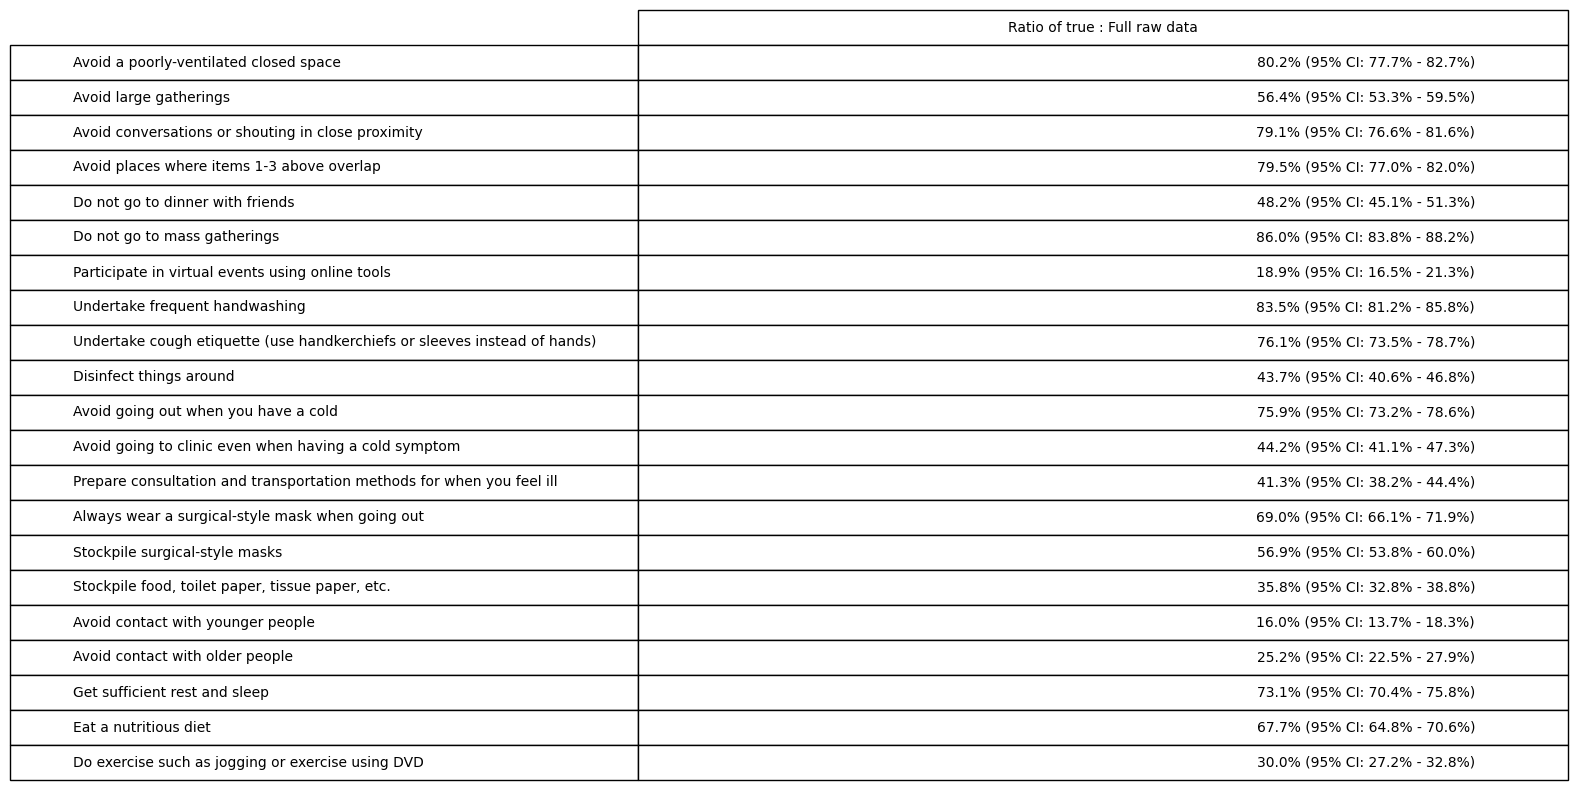

In [272]:
df_sampled_full_raw_data_aggregate = aggregate_data_df(df_sampled_full_raw_data_extract, list_questions, list_options)
df_sampled_full_raw_data_calculated = calculate_ratio(df_sampled_full_raw_data_aggregate.T, "Full raw data")
table_plot(df_sampled_full_raw_data_calculated, 10, 10)

In [278]:
import pandas as pd
import numpy as np
from scipy.stats import norm

def calculate_ratio_with_confidence_interval(df_aggregate, attribute):
    df_ratio = pd.DataFrame()

    # Calculate the standard error
    n = df_aggregate.sum(axis=1)
    p = (df_aggregate["Very true"] + df_aggregate["True"]) / n

    se = np.sqrt((p * (1 - p)) / n) 
    
    # Calculate the confidence interval
    z = norm.ppf(0.975)  # 95% confidence
    lower = round((p - z * se) * 100, 1) 
    upper = round((p + z * se)* 100, 1) 
    
    df_ratio[f"Ratio"] = round(p * 100, 1)
    df_ratio[f"Lower"] = lower
    df_ratio[f"Upper"] = upper

    return df_ratio

df_sampled_full_raw_data_calculated = calculate_ratio_with_confidence_interval(df_sampled_full_raw_data_aggregate.T, "Full raw data")
df_all_calculated = calculate_ratio_with_confidence_interval(df_aggregate.T, "All")
display(df_sampled_full_raw_data_calculated.head())
display(df_all_calculated.head())

,Ratio,Lower,Upper
Avoid a poorly-ventilated closed space,80.2,77.7,82.7
Avoid large gatherings,56.4,53.3,59.5
Avoid conversations or shouting in close proximity,79.1,76.6,81.6
Avoid places where items 1-3 above overlap,79.5,77.0,82.0
Do not go to dinner with friends,48.2,45.1,51.3


,Ratio,Lower,Upper
Avoid a poorly-ventilated closed space,91.0,89.2,92.8
Avoid large gatherings,90.5,88.7,92.3
Avoid conversations or shouting in close proximity,92.6,91.0,94.2
Avoid places where items 1-3 above overlap,92.2,90.5,93.9
Do not go to dinner with friends,63.5,60.5,66.4


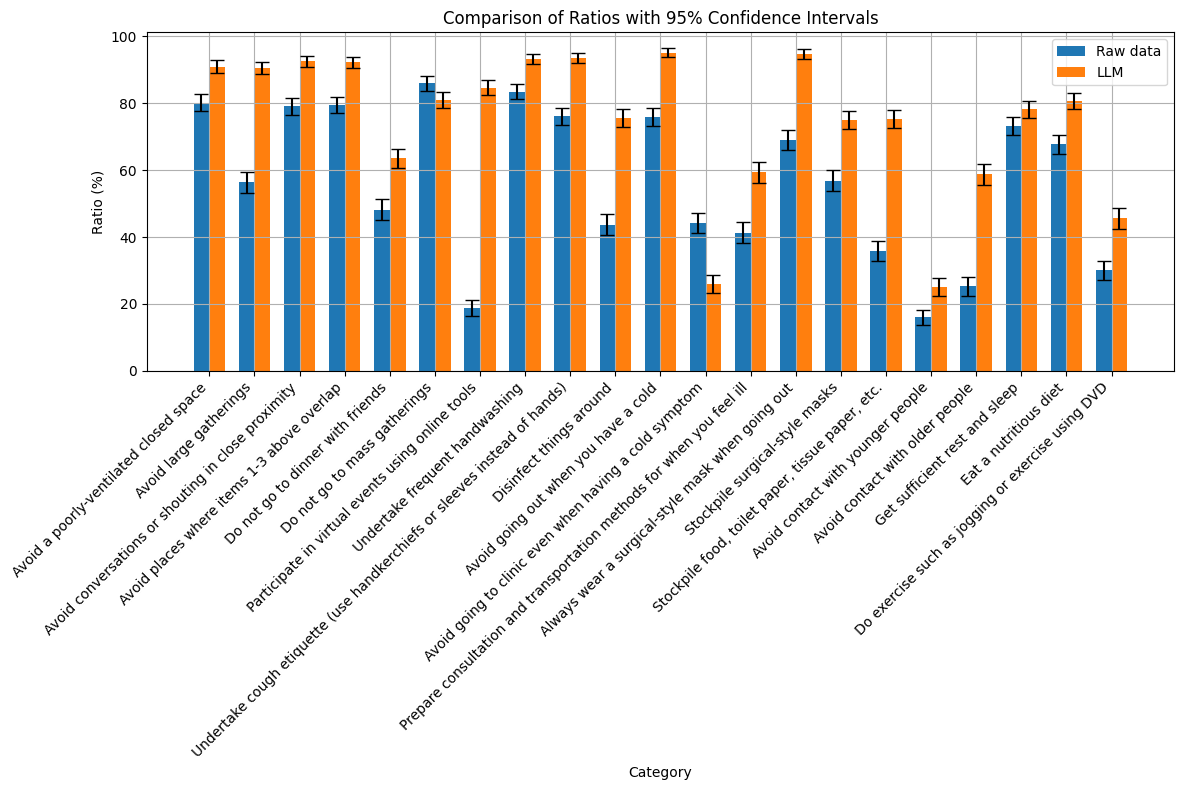

In [281]:
df_full = df_sampled_full_raw_data_calculated
df_all = df_all_calculated
# グラフ作成
fig, ax = plt.subplots(figsize=(12, 8))

# 棒グラフの位置を設定
x = np.arange(len(df_full))

# 棒グラフをプロット
bar_width = 0.35
ax.bar(x - bar_width/2, df_full['Ratio'], bar_width, label='Raw data', yerr=[df_full['Ratio'] - df_full['Lower'], df_full['Upper'] - df_full['Ratio']], capsize=5)
ax.bar(x + bar_width/2, df_all['Ratio'], bar_width, label='LLM', yerr=[df_all['Ratio'] - df_all['Lower'], df_all['Upper'] - df_all['Ratio']], capsize=5)

# 軸とタイトルのラベルを設定
ax.set_xlabel('Category')
ax.set_ylabel('Ratio (%)')
ax.set_title('Comparison of Ratios with 95% Confidence Intervals')
ax.set_xticks(x)
ax.set_xticklabels(df_full.index.tolist(), rotation=45, ha='right')
ax.legend()

# グリッドを表示
ax.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

In [269]:
df_full_raw_data = pd.read_csv("Terms_of_Use/rawdata.csv")
df_sampled_full_raw_data = df_full_raw_data.sample(1000, random_state=42)
dict_option_number = {k + 1 : v for k, v in enumerate(list_options)}
print(dict_option_number)
df_sampled_full_raw_data_extract = df_sampled_full_raw_data.iloc[:,22:43].replace(dict_option_number)

df_sampled_full_raw_data_aggregate = aggregate_data_df(df_sampled_full_raw_data_extract, list_questions, list_options)
df_sampled_full_raw_data_calculated = calculate_ratio(df_sampled_full_raw_data_aggregate.T, "Full raw data")
table_plot(df_sampled_full_raw_data_calculated, 10, 10)

{1: 'Very true', 2: 'True', 3: 'Neither', 4: 'Not true', 5: 'Not at all'}


KeyError: 'Avoid a poorly-ventilated closed space'

In [251]:
import pickle
def load_data_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

In [252]:
df_answer = load_data_from_pickle("0716_file/sample_answers_1000.pkl")
df_answer.head()

,The government should allow mass gatherings now,The government should continue to request self-restraint of mass gatherings,The government should limit movement in addition to mass gatherings,"Extraverted, enthusiastic","Critical, quarrelsome","Dependable, self-disciplined","Anxious, easily upset","Open to new experiences, complex","Reserved, quiet","Sympathetic, warm",...,"Conventional, uncreative",DRINK,SMOKE,AGE,SEX,MARRIED,GRADUATE UNIVERSITY,CHILD,WORK,HOUSE INCOME
0,Neither,Neither,Neither,Disagree strongly,Disagree strongly,Disagree strongly,Agree,Agree,Disagree,Disagree,...,Agree,1-2 times per week,Never smoked,50-54,Male,Not married,No,Yes,Regular employee,Unanswered
1,Disagree,Agree,Neither,Agree,Disagree strongly,Disagree strongly,Disagree,Disagree,Disagree strongly,Agree strongly,...,Agree,3-6 times per week,Never smoked,45-49,Female,Not married,Yes,No,Regular employee,"12,000-14,999K JPY"
2,Relatively agree,Relatively agree,Relatively disagree,Disagree,Disagree,Agree,Agree,Disagree,Agree,Agree,...,Agree,Every day,Used to smoke but do not now,50-54,Female,Not married,No,No,Non-regular employee,Unanswered
3,Neither,Neither,Neither,Disagree strongly,Disagree strongly,Disagree strongly,Disagree strongly,Agree,Agree,Agree,...,Disagree strongly,Never drink,Every day,50-54,Male,Married,No,No,Self-employed and others,"2,000-3,999K JPY"
4,Agree,Agree,Agree,Agree,Agree,Disagree strongly,Agree strongly,Agree,Agree,Agree,...,Agree strongly,3-6 times per week,Every day,50-54,Female,Married,No,No,Non-regular employee,"Less than 2,000K JPY"


In [150]:


# Define filters
filters_to_preprocess = {
    'DRINK': {("Never drink", "I used to drink, but I quitted", "Few times per month", "1-2 times per week"): 0,
              ("3-6 times per week", "Every day"): 1},
    'SMOKE': {("Never smoked", "Used to smoke but do not now"): 0,
              ("Sometimes", "Every day"): 1},
    'AGE': {("20-24","25-29"):"20s",("30-34","35-39"):"30s",("40-44","45-49"):"40s",("50-54","55-59"):"50s",("60-64"):"60s"},
    'SEX': {"Male": 1, "Female": 0},
    'MARRIED': {"Not married": 0, "Married": 1},
    'GRADUATE UNIVERSITY': {"No": 0, "Yes": 1},
    'CHILD': {"No": 0, "Yes": 1}
}
filter_to_preprocess_response = {
    "Avoid places where items 1-3 above overlap":{("Very true","True","Neither"):0,("Not true","Not at all"):1},
}

def apply_filter(value, filter_dict):
    for keys, val in filter_dict.items():
        if value in keys:
            return val
    return value

def preprocess_df_answer(df, filters):
    # Apply filters
    df_return = df.copy()
    for column, filter_dict in filters.items():
        if column in df.columns:
            if isinstance(list(filter_dict.keys())[0], tuple):
                df_return[column] = df[column].apply(lambda x: apply_filter(x, filter_dict))
            else:
                df_return[column] = df[column].map(filter_dict)

    # One-hot encoding for AGE, WORK, and HOUSE INCOME
    df_return = pd.get_dummies(df_return, columns=['AGE', 'WORK', 'HOUSE INCOME'], prefix=['AGE', 'WORK', 'HOUSE_INCOME'], dtype=int)

    return df_return

def preprocess_df_response(df, filters):
    df_return = df.copy()
    for column, filter_dict in filters.items():
        if column in df.columns:
            if isinstance(list(filter_dict.keys())[0], tuple):
                df_return[column + " binary"] = df[column].apply(lambda x: apply_filter(x, filter_dict))
            else:
                df_return[column + " binary"] = df[column].map(filter_dict)
    return df_return




In [151]:
def remove_leading_number_and_period(text):
    if isinstance(text, str):
        return re.sub(r'^\d+\.', '', text)
    return text

def remove_number_and_period_dataframe(df):
    return df.applymap(remove_leading_number_and_period)


In [152]:
df_answer_preprocessed = preprocess_df_answer(df_answer, filters_to_preprocess)
df_answer_preprocessed_split=df_answer_preprocessed.iloc[:,13:]


In [153]:
df_sampled_responses_extract_removed = remove_number_and_period_dataframe(df_sampled_responses_extract)
df_sampled_responses_extract_preprocessed = preprocess_df_response(df_sampled_responses_extract_removed, filter_to_preprocess_response)


In [154]:
df_merged = pd.merge(df_sampled_responses_extract_preprocessed,df_answer_preprocessed_split, left_index=True, right_index=True)
df_merged.head(10)

,Avoid a poorly-ventilated closed space,Avoid large gatherings,Avoid conversations or shouting in close proximity,Avoid places where items 1-3 above overlap,Do not go to dinner with friends,Do not go to mass gatherings,Participate in virtual events using online tools,Undertake frequent handwashing,Undertake cough etiquette (use handkerchiefs or sleeves instead of hands),Disinfect things around,...,"HOUSE_INCOME_12,000-14,999K JPY","HOUSE_INCOME_15,000-19,999K JPY","HOUSE_INCOME_2,000-3,999K JPY","HOUSE_INCOME_4,000-5,999K JPY","HOUSE_INCOME_6,000-6,999K JPY","HOUSE_INCOME_8,000-8,999K JPY",HOUSE_INCOME_Do not know,"HOUSE_INCOME_Less than 2,000K JPY","HOUSE_INCOME_More than 20,000K JPY",HOUSE_INCOME_Unanswered
0,Neither,Neither,Neither,Neither,Neither,Neither,Neither,Neither,Neither,Neither,...,0,0,0,0,0,0,0,0,0,1
1,True,Very true,True,True,Not true,Very true,True,True,True,True,...,1,0,0,0,0,0,0,0,0,0
2,True,True,True,True,Not true,True,True,Very true,Very true,True,...,0,0,0,0,0,0,0,0,0,1
3,True,Neither,True,True,Neither,Neither,True,True,True,True,...,0,0,1,0,0,0,0,0,0,0
4,Not true,True,True,Not true,Not true,Not true,Neither,Not true,True,Not true,...,0,0,0,0,0,0,0,1,0,0
5,True,True,True,True,True,True,True,True,True,True,...,0,0,0,0,0,0,0,0,0,1
6,True,Very true,True,Very true,True,Very true,True,True,True,Not true,...,0,0,0,0,0,0,1,0,0,0
7,Very true,Very true,Very true,Very true,Very true,Very true,Very true,Very true,Very true,Neither,...,0,0,0,0,1,0,0,0,0,0
8,Very true,Very true,Very true,Very true,Very true,Very true,Very true,Very true,Very true,Very true,...,0,0,0,0,0,0,0,1,0,0
9,Very true,Very true,Very true,Very true,True,Very true,True,Very true,Very true,Very true,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
def calculate_column_odds_ratio(df):
    series_base_column = df[df.columns[0]]
    list_odds_ratios = []
    for column in df.columns:
        series_column = df[column]
        TP = sum((series_base_column == 1) & (series_column == 1))
        TN = sum((series_base_column == 0) & (series_column == 0))
        FP = sum((series_base_column == 0) & (series_column == 1))
        FN = sum((series_base_column == 1) & (series_column == 0))
        print(TP,TN,FP,FN)
        if FP * FN == 0:
            odds_ratio = 0.0
        else:
            odds_ratio = round((TP * TN) / (FP * FN),2)
        list_odds_ratios.append(odds_ratio)
    return list_odds_ratios

df_merged_split_2=df_merged.iloc[:,21:]
print(df_merged_split_2.shape)
list_df_merged_odds=calculate_column_odds_ratio(df_merged_split_2)

In [172]:
df_merged_split_2.fillna(0,inplace=True)
df_merged_split_2.astype(int)

In [246]:
# 必要なライブラリをインポート
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.api as sm

# データを読み込む
data = df_merged_split_2.replace("None", 0).astype(int)

# データの前処理（例: 欠損値の処理、カテゴリ変数のエンコーディングなど）
# ここでは仮に 'X1', 'X2', 'X3' が説明変数、 'Y' が目的変数とします
# 必要に応じて前処理を追加してください

# 説明変数と目的変数を定義
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# statsmodels でロジスティック回帰モデルを構築
X = sm.add_constant(X)  # 定数項を追加
model = sm.Logit(y, X)
result = model.fit()

# モデルの係数を取得
coefficients = result.params
conf = result.conf_int()
conf['OR'] = coefficients
conf.columns = ['2.5%', '97.5%', 'OR']

# オッズ比を計算
odds_ratios = round(np.exp(coefficients),3)

# p値を取得
p_values = result.pvalues

# 結果を表示
#for feature in X.columns:
#    print(f'{feature}: オッズ比 = {odds_ratios[feature]}, 95% CI = [{np.exp(conf.loc[feature, "2.5%"])}, {np.exp(conf.loc[feature, "97.5%"])}], p値 = {p_values[feature]}')

# 結果をDataFrameにまとめる
results = pd.DataFrame({
    'Odds ratio': odds_ratios,
    '95% CI Lower': round(np.exp(conf.loc[:, "2.5%"]),3),
    '95% CI Upper': round(np.exp(conf.loc[:, "97.5%"]),3),
    'p value': round(p_values,3)
})

# 結果を表示
display(results)

         Current function value: 0.049429
         Iterations: 35


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Odds ratio,95% CI Lower,95% CI Upper,p value
const,0.000,0.000,inf,1.000
DRINK,4.195,1.142,15.411,0.031
SMOKE,4.820,1.208,19.237,0.026
SEX,1.658,0.375,7.320,0.505
MARRIED,1.842,0.438,7.740,0.404
GRADUATE UNIVERSITY,0.137,0.027,0.694,0.016
CHILD,1.588,0.280,9.014,0.602
AGE_20s,0.551,NaN,NaN,NaN
AGE_30s,0.219,NaN,NaN,NaN
AGE_40s,0.032,NaN,NaN,NaN


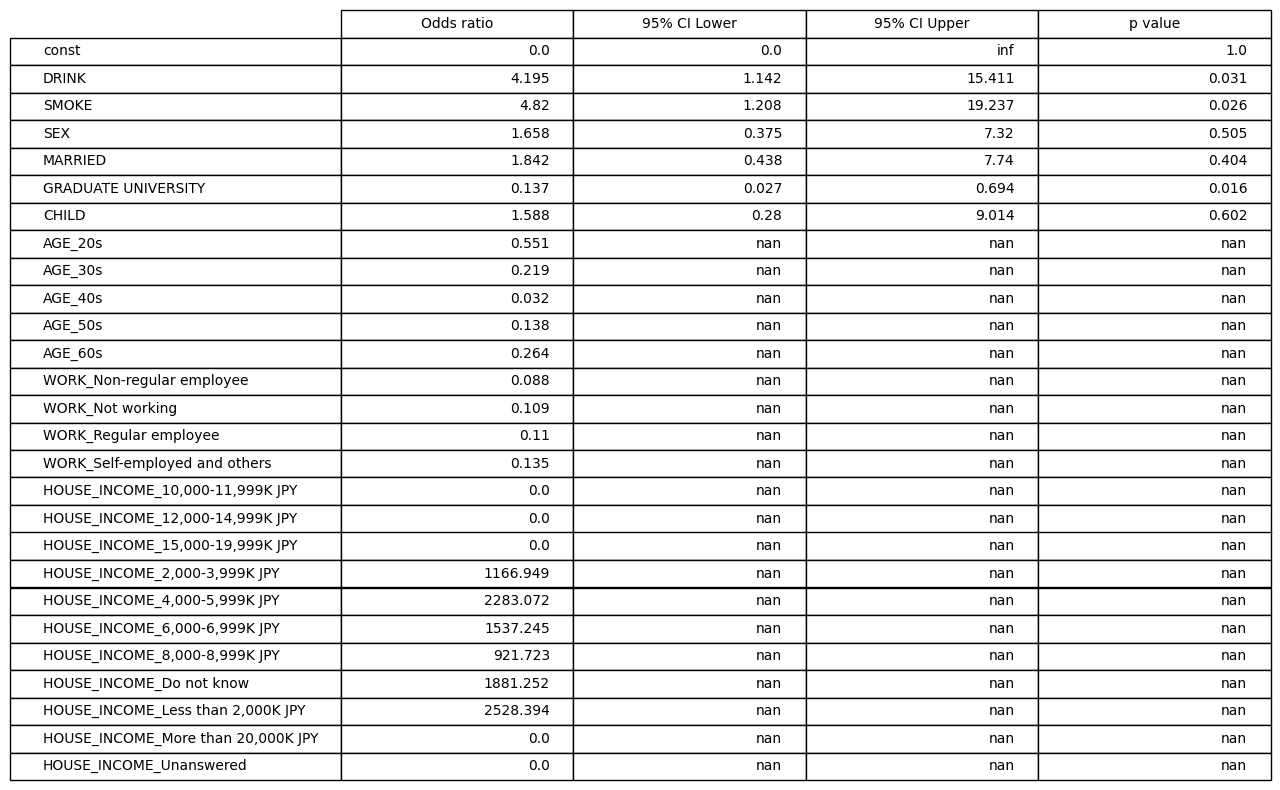

In [249]:
table_plot(results, 10, 10)

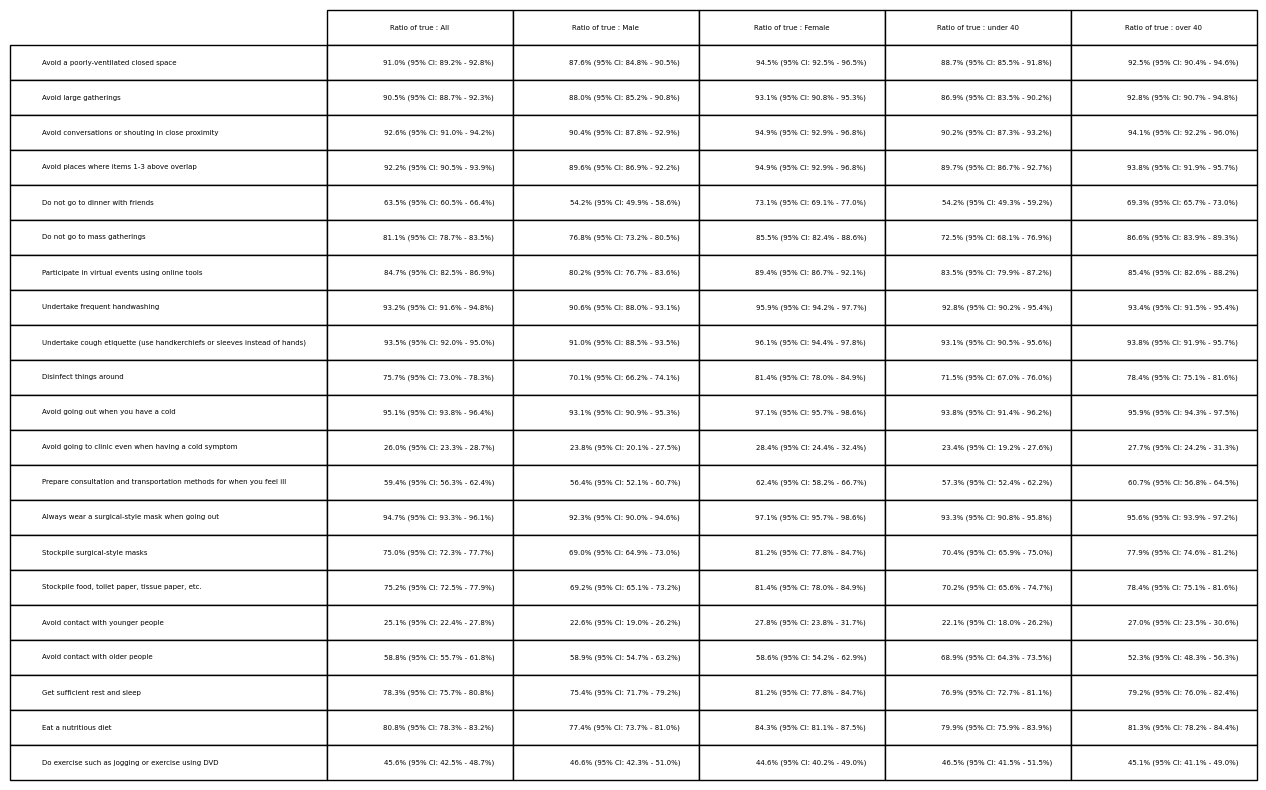

In [248]:
def table_plot(df, width, height, font_size=7):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc='center',
        bbox=[0, 0, 1.2, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    plt.show()

df_aggregate = aggregate_data_df(df_sampled_responses_extract_removed, list_questions, list_options)
df_calculate = calculate_ratio(df_aggregate.T, "All")

#separate by age
df_u40 = df_merged[(df_merged["AGE_20s"] == 1)|(df_merged["AGE_30s"] == 1)]
df_o40 = df_merged[(df_merged["AGE_40s"] == 1)|(df_merged["AGE_50s"] == 1)|(df_merged["AGE_60s"] == 1)]
df_aggregate_u40 = aggregate_data_df(df_u40.iloc[:,:21], list_questions, list_options)
df_aggregate_o40 = aggregate_data_df(df_o40.iloc[:,:21], list_questions, list_options)
df_calculate_u40 = calculate_ratio(df_aggregate_u40.T, "under 40")
df_calculate_o40 = calculate_ratio(df_aggregate_o40.T, "over 40")

#separate by sex
df_male = df_merged[df_merged["SEX"] == 1]
df_female = df_merged[df_merged["SEX"] == 0]
df_aggregate_male = aggregate_data_df(df_male.iloc[:,:21], list_questions, list_options)
df_aggregate_female = aggregate_data_df(df_female.iloc[:,:21], list_questions, list_options)
df_calculate_male = calculate_ratio(df_aggregate_male.T, "Male")
df_calculate_female = calculate_ratio(df_aggregate_female.T, "Female")

df_calculate_merged = pd.concat([df_calculate,df_calculate_male,df_calculate_female,df_calculate_u40, df_calculate_o40], axis=1)
table_plot(df_calculate_merged, 10, 10)